##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using LSTMs, CNNs, GRUs with a larger dataset

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c02_nlp_multiple_models_for_predicting_sentiment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c02_nlp_multiple_models_for_predicting_sentiment.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this colab, you use different kinds of layers to see how they affect the model.

You will use the glue/sst2 dataset, which is available through tensorflow_datasets.

The General Language Understanding Evaluation (GLUE) benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems.

These resources include the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment. This colab uses version 2 of the SST dataset.

The splits are:

*   train	67,349
*   validation	872


and the column headings are:

*   sentence
*   label


For more information about the dataset, see [https://www.tensorflow.org/datasets/catalog/glue#gluesst2](https://www.tensorflow.org/datasets/catalog/glue#gluesst2)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Get the dataset


In [3]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.HQNB9O_2.0.0/glue-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.HQNB9O_2.0.0/glue-validation.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.HQNB9O_2.0.0/glue-test.tfrecord*...:   0%|          |…

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [4]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [5]:
# Print some of the entries
for example in dataset_train.take(2):
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [6]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences


In [7]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


# Pad the sequences

In [8]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [10]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5559 - loss: 0.6834 - val_accuracy: 0.5275 - val_loss: 0.6897
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5730 - loss: 0.6765 - val_accuracy: 0.5894 - val_loss: 0.6790
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5933 - loss: 0.6671 - val_accuracy: 0.6239 - val_loss: 0.6607
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6366 - loss: 0.6453 - val_accuracy: 0.6514 - val_loss: 0.6327
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6815 - loss: 0.6178 - val_accuracy: 0.7190 - val_loss: 0.6022
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7166 - loss: 0.5852 - val_accuracy: 0.7362 - val_loss: 0.5713
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7427 - loss: 0.5560 - val_accuracy: 0.7397 - val_loss: 0.5487
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7694 - loss: 0.5211 - val_accuracy: 0.

# Plot the accurracy and loss

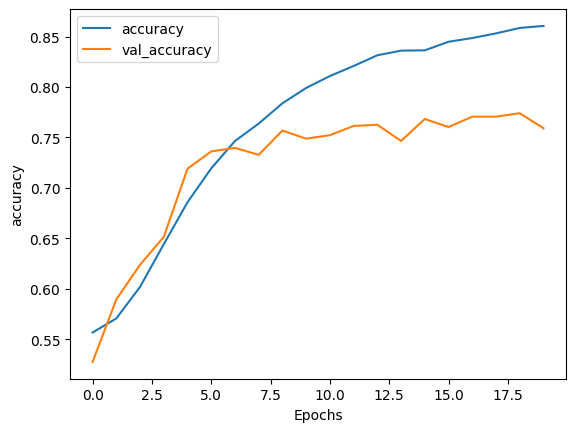

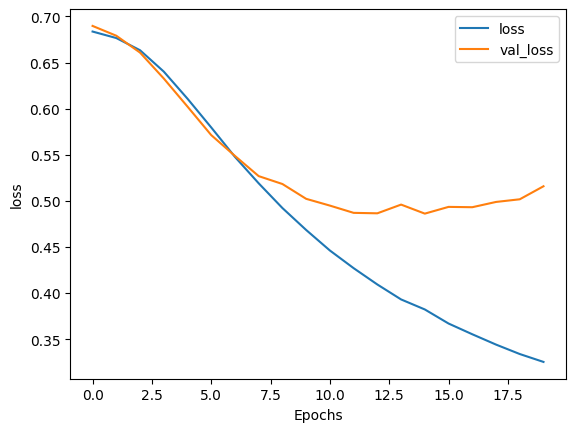

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [12]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [13]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
I loved this movie
[0.43548566]


that was the worst movie I've ever seen
[0.14685157]


too much violence even for a Bond film
[0.04352875]


a captivating recounting of a cherished myth
[0.6464053]




# Define a function to train and show the results of models with different layers

In [14]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# Use a CNN

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5350 - loss: 0.6910 - val_accuracy: 0.5092 - val_loss: 0.6929
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5599 - loss: 0.6835 - val_accuracy: 0.5092 - val_loss: 0.6928
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5589 - loss: 0.6797 - val_accuracy: 0.5092 - val_loss: 0.6911
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5582 - loss: 0.6755 - val_accuracy: 0.5092 - val_loss: 0.6875
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5607 - loss: 0.6685 - val_accuracy: 0.5573 - val_loss: 0.6812
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5925 - loss: 0.6589 - val_accuracy: 0.6089 - val_loss: 0.6728
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6337 - loss: 0.6464 - val_accuracy: 0.6789 - val_loss: 0.6599
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6914 - loss: 0.6245 - val_accuracy: 0.

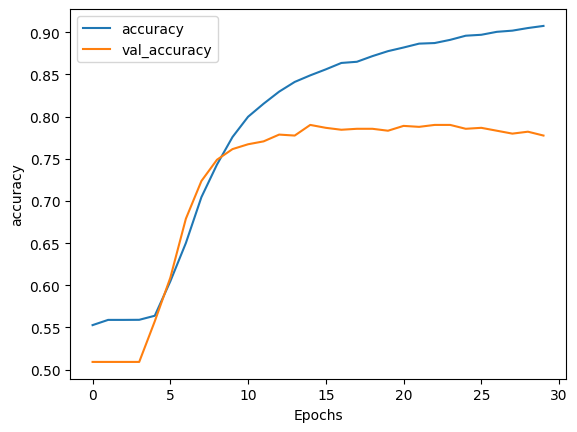

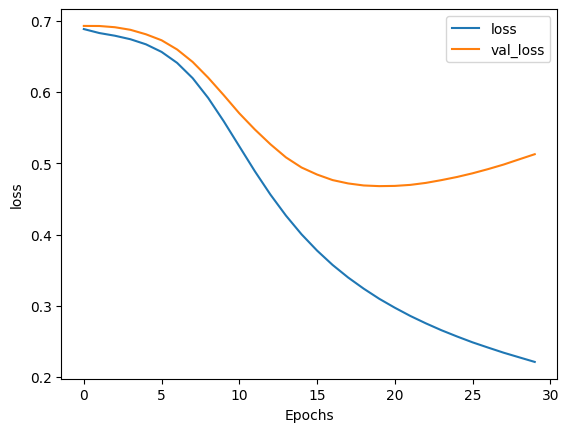

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
I loved this movie
[0.53864413]


that was the worst movie I've ever seen
[0.01107945]


too much violence even for a Bond film
[0.00885552]


a captivating recounting of a cherished myth
[0.6276195]




In [15]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5501 - loss: 0.6913 - val_accuracy: 0.5092 - val_loss: 0.6931
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5735 - loss: 0.6850 - val_accuracy: 0.5092 - val_loss: 0.6945
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5551 - loss: 0.6858 - val_accuracy: 0.5092 - val_loss: 0.6965
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5590 - loss: 0.6836 - val_accuracy: 0.5092 - val_loss: 0.6991
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5630 - loss: 0.6812 - val_accuracy: 0.5092 - val_loss: 0.7025
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5469 - loss: 0.6827 - val_accuracy: 0.5092 - val_loss: 0.7103
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5631 - loss: 0.6753 - val_accuracy: 0.5092 - val_loss: 0.7200
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5635 - loss: 0.6713 - val_accuracy: 

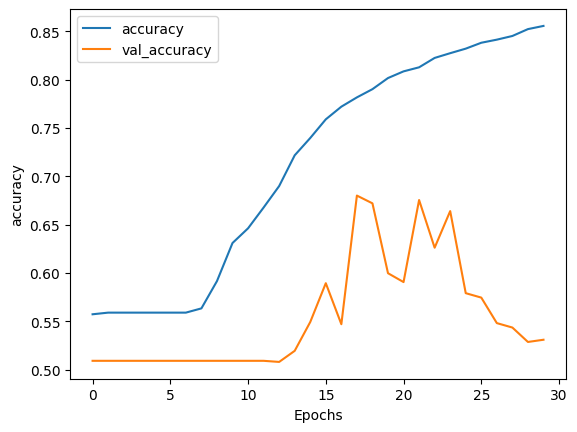

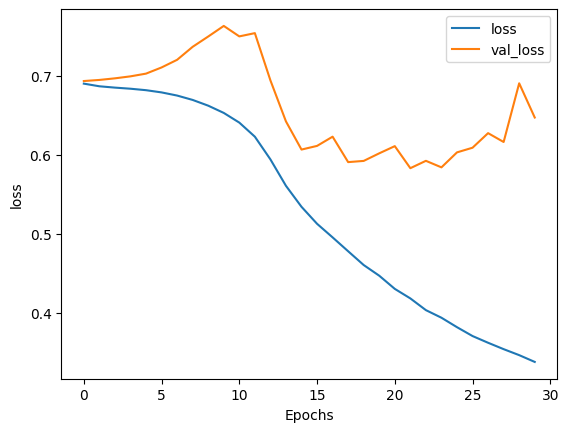

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
I loved this movie
[0.38441962]


that was the worst movie I've ever seen
[0.12405245]


too much violence even for a Bond film
[0.05226224]


a captivating recounting of a cherished myth
[0.49612722]




In [16]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Add a bidirectional LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5538 - loss: 0.6914 - val_accuracy: 0.5092 - val_loss: 0.6931
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5541 - loss: 0.6881 - val_accuracy: 0.5092 - val_loss: 0.6940
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5454 - loss: 0.6875 - val_accuracy: 0.5092 - val_loss: 0.6955
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5561 - loss: 0.6844 - val_accuracy: 0.5092 - val_loss: 0.6970
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5585 - loss: 0.6828 - val_accuracy: 0.5092 - val_loss: 0.6991
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5685 - loss: 0.6786 - val_accuracy: 0.5092 - val_loss: 0.7020
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5572 - loss: 0.6791 - val_accuracy: 0.5092 - val_loss: 0.7077
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5563 - loss: 0.6766 - val_accuracy:

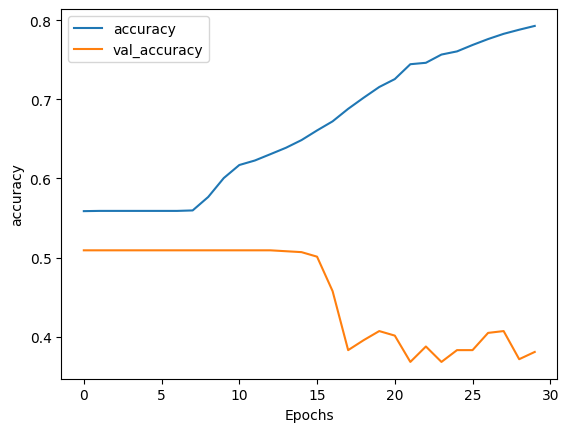

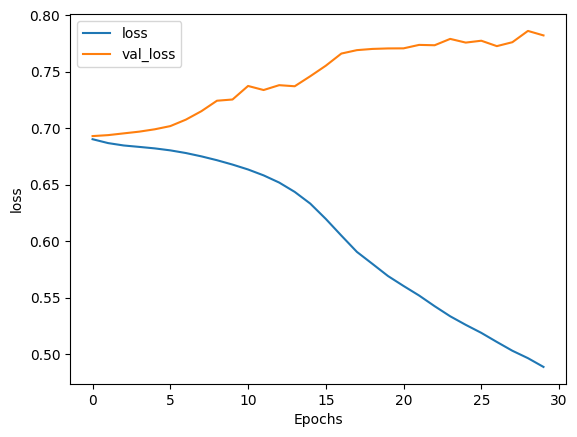

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
I loved this movie
[0.48562902]


that was the worst movie I've ever seen
[0.34404486]


too much violence even for a Bond film
[0.4135445]


a captivating recounting of a cherished myth
[0.49277765]




In [24]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5550 - loss: 0.6862 - val_accuracy: 0.5092 - val_loss: 0.7102
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6684 - loss: 0.6190 - val_accuracy: 0.4885 - val_loss: 0.7085
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8179 - loss: 0.3996 - val_accuracy: 0.5103 - val_loss: 0.7422
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8520 - loss: 0.3259 - val_accuracy: 0.5092 - val_loss: 1.2865
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8845 - loss: 0.2726 - val_accuracy: 0.4438 - val_loss: 0.7290
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8884 - loss: 0.2607 - val_accuracy: 0.5046 - val_loss: 0.8783
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8983 - loss: 0.2317 - val_accuracy: 0.4186 - val_loss: 0.8603
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9057 - loss: 0.2175 - val_acc

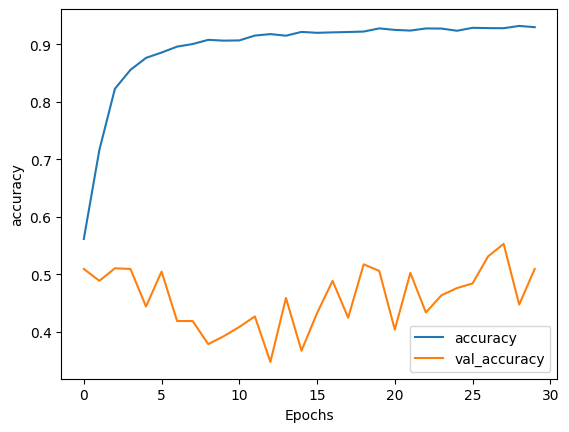

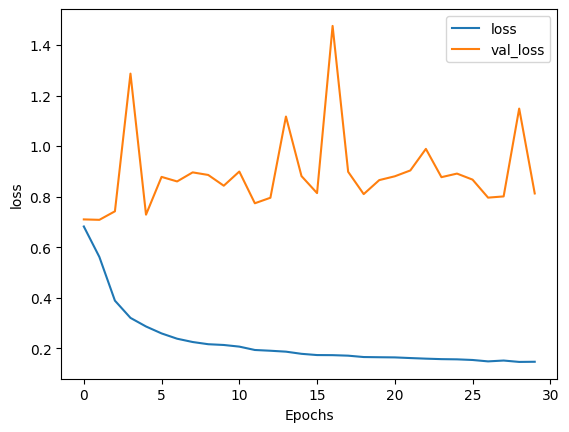

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
I loved this movie
[0.34945205]


that was the worst movie I've ever seen
[0.64590615]


too much violence even for a Bond film
[0.02207096]


a captivating recounting of a cherished myth
[0.9919425]




In [25]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [26]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
               review8, review9, review10]


In [27]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
I loved this movie
[0.43548566]


that was the worst movie I've ever seen
[0.14685157]


too much violence even for a Bond film
[0.04352875]


a captivating recounting of a cherished myth
[0.6464053]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.270914]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.49742535]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.23870905]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.52742845]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedi

In [28]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
I loved this movie
[0.53864413]


that was the worst movie I've ever seen
[0.01107945]


too much violence even for a Bond film
[0.00885552]


a captivating recounting of a cherished myth
[0.6276195]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.56720954]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.96316713]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.47423542]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.66251266]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 

In [29]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
I loved this movie
[0.38441962]


that was the worst movie I've ever seen
[0.12405245]


too much violence even for a Bond film
[0.05226224]


a captivating recounting of a cherished myth
[0.49612722]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.07957106]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.3625475]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.1954082]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.2615991]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in th

In [30]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
I loved this movie
[0.48562902]


that was the worst movie I've ever seen
[0.34404486]


too much violence even for a Bond film
[0.4135445]


a captivating recounting of a cherished myth
[0.49277765]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.266611]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.2990186]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.23663758]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.48083568]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoi

In [31]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
I loved this movie
[0.34945205]


that was the worst movie I've ever seen
[0.64590615]


too much violence even for a Bond film
[0.02207096]


a captivating recounting of a cherished myth
[0.9919425]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.07709572]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.98639625]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.9486608]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99583495]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disapp